In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import sklearn

from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import hstack
from sklearn.ensemble import VotingRegressor

!pip install catboost
from catboost import CatBoostRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

!pip install lightgbm
from lightgbm import LGBMRegressor

import xgboost as xgb

In [ ]:
def preprocessing_data(df: pd.DataFrame, train: bool()) -> tuple():
    """ Data preproccessing """

    df.drop(columns='id', inplace=True)

    # приводим дату к типу даты
    df["date"] = pd.DatetimeIndex(df["date"])

    df.build_tech = df.build_tech.fillna(value=df.g_lift.median())

    df.g_lift = df.g_lift.fillna(value=df.g_lift.median())
    
    df.metro_dist = df.metro_dist.fillna(value=df.metro_dist.mean())

    df.build_tech[99999] = 1.0

    df = df.astype({'build_tech' : 'Int64',
                    'g_lift' : 'Int64'})

    df.build_tech.apply(lambda x: int(x))

    df.g_lift.apply(lambda x: int(x))

    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month

    df = pd.concat([df, pd.get_dummies(df.month, prefix='month')], axis=1)

    df = pd.concat([df, pd.get_dummies(df.floor, prefix='floor')], axis=1)

    df = pd.concat([df, pd.get_dummies(df.rooms, prefix='rooms')], axis=1)

    df = df.drop(columns=['date', 'floor', 'n_photos', 'rooms', 'month'])

    return df

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/d3vyatk4ru/DZ5ML/main/Train.csv')

In [ ]:
df

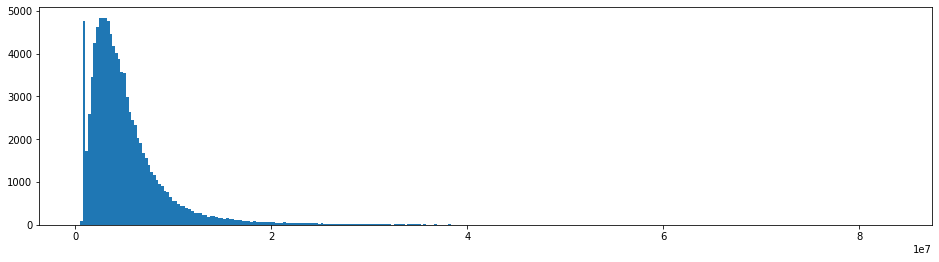

In [ ]:
plt.figure(figsize=(16, 4))
plt.hist(df.price, bins=300);

In [ ]:
df = df[~df.isnull()]

In [ ]:
df = preprocessing_data(df, train=False)

In [ ]:
df = df[df.price != 1_000_000]

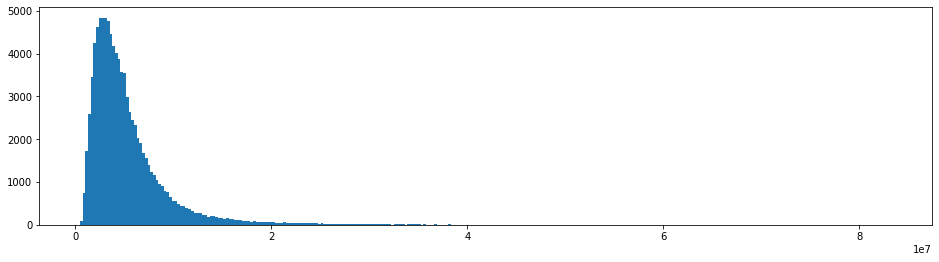

In [ ]:
plt.figure(figsize=(16, 4))
plt.hist(df.price, bins=300);

In [ ]:
y = df.price.values
X = df.drop(columns='price').values
del df

In [ ]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

In [ ]:
quadratic = PolynomialFeatures(degree=2)

In [ ]:
X_q = quadratic.fit_transform(X_scaler)
del X_scaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_q, y, test_size=0.15, random_state=42)
del X_q

In [ ]:
LGBM = LGBMRegressor(learning_rate=0.6,
                   n_estimators=250,
                   random_state=42,
                   num_leaves=1024,
                   reg_alpha=1e-2,
                   reg_lambda=1e-2)


catboostRMSE = CatBoostRegressor(learning_rate=0.8,
                          n_estimators=300,
                          loss_function="RMSE",
                          score_function='L2',
                          random_state=24,
                          reg_lambda=10)

catboostMAE = CatBoostRegressor(learning_rate=0.8,
                          n_estimators=300,
                          loss_function="MAE",
                          random_state=42,
                          reg_lambda=1e+2)

In [ ]:
voting = VotingRegressor([('LGBM', LGBM), ('catboostRMSE', catboostRMSE), ('catboostMAE', catboostMAE)])

In [ ]:
voting.fit(X_train, y_train)

In [ ]:
y_pred = voting.predict(X_test)

In [ ]:
mean_absolute_error(y_test, y_pred)

In [ ]:
print(abs(y_pred - y_test)).mean()
print(abs(y_pred - y_test)).max()
print(abs(y_pred - y_test).min())

In [ ]:
df_test = pd.read_csv('https://raw.githubusercontent.com/d3vyatk4ru/DZ5ML/main/Test.csv')
y = df_test.id.values

In [ ]:
df_test = preprocessing_data(df_test, train=False)

In [ ]:
X = df_test.values

In [ ]:
X_test_scaler = scaler.transform(X)

In [ ]:
X_test_quadratic = quadratic.transform(X_test_scaler)

In [ ]:
y_tmp = voting.predict(X_test_quadratic)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.DataFrame()
df['id'] = y
df['price'] = y_prev.price
df.to_csv("/content/drive/MyDrive/price_flat_night0412+300k.csv", index=False)